In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import stdev
import scipy.stats as sp
import arch
import contextlib
import io
import sys

In [3]:
copper = pd.read_csv('../data/copper.csv')
copper

,Date,Close/Last,Volume,Open,High,Low
0,04/14/2023,4.1065,98124,4.1285,4.1955,4.0950
1,04/13/2023,4.1240,88437,4.0700,4.1430,4.0535
2,04/12/2023,4.0810,88325,4.0295,4.0880,3.9840
3,04/11/2023,4.0195,81243,3.9870,4.0540,3.9780
4,04/10/2023,3.9765,53745,4.0180,4.0395,3.9630
...,...,...,...,...,...,...
1255,04/20/2018,3.1555,33960,3.1490,3.1685,3.1275
1256,04/19/2018,3.1540,37634,3.1835,3.2180,3.1350
1257,04/18/2018,3.1815,51721,3.1100,3.2015,3.0995
1258,04/17/2018,3.0795,88784,3.0835,3.1020,3.0545


# WAŻONA


In [40]:
def hist_weight_fun(lam,ps,x):
    n = len(x)
    lambda_s = [lam**i for i in range(1,n)]
    
    ws = np.zeros((n))
    ws[0] = 1/(1+sum(lambda_s))
    ws[1:] = [ws[0]*lam**i for i in range(1,n)]

    m = np.array([x,ws])
    mt = np.transpose(m)
    hist_weight = pd.DataFrame(mt,columns=['L','w'])
    hist_weight = hist_weight.sort_values(by=['L'])
    hist_weight = hist_weight.reset_index(drop=True)

    hist_weight['w_s'] = np.zeros(n)
    for i in range(0,n):
        hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

    result = [float(hist_weight.iloc[(hist_weight['w_s']-p).abs().argsort()[:1]]['L']) for p in ps]
    return(result)

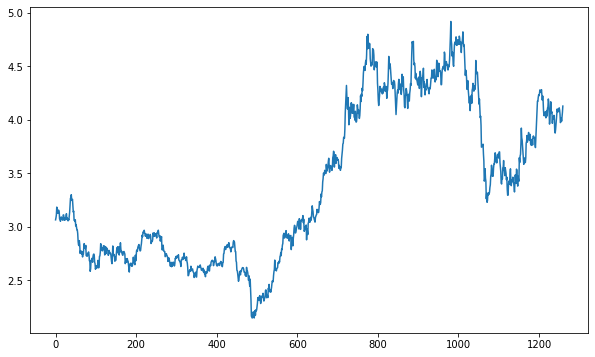

In [5]:
Y = np.array(copper.Open.values[::-1])

plt.figure(figsize=(10, 6))
plt.plot(Y)
plt.show()

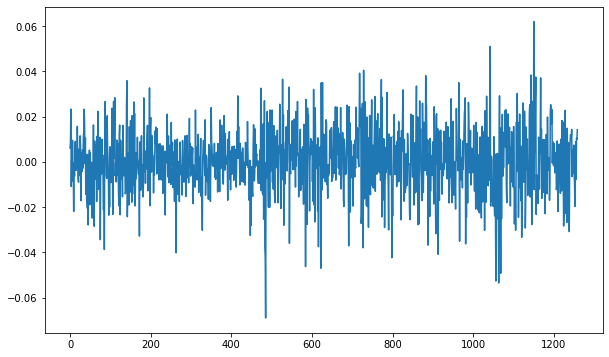

In [34]:
Y = np.array(copper.Open.values[::-1])
X = np.log(Y[1:] / Y[:-1])

plt.figure(figsize=(10, 6))
plt.plot(X)
plt.show()

In [7]:
np.quantile(X, 0.99)

0.035013291334181094

# GARCH

In [8]:
with contextlib.redirect_stdout(io.StringIO()):
    model = arch.arch_model(X, vol='GARCH', p=1, q=1)
    results = model.fit()
    print(results.summary())

c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [9]:
sys.stdout = open('devnull', 'w')

model = arch.arch_model(X, vol='GARCH', p=1, q=1)
results = model.fit()
print(results.summary())

sys.stdout = sys.__stdout__

c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


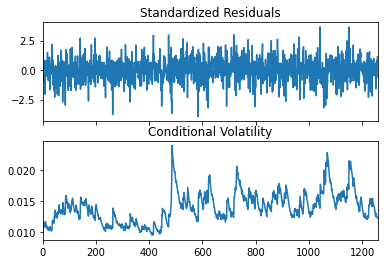

In [10]:
results.plot()
plt.show()

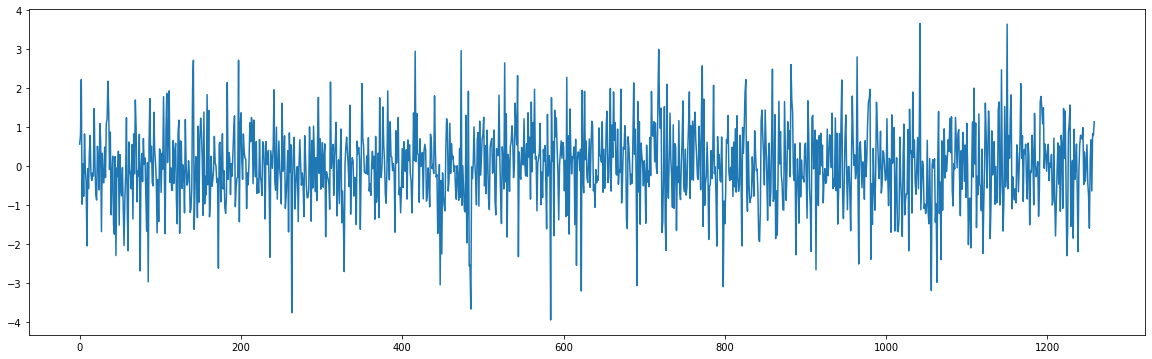

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(results.std_resid)
plt.show()

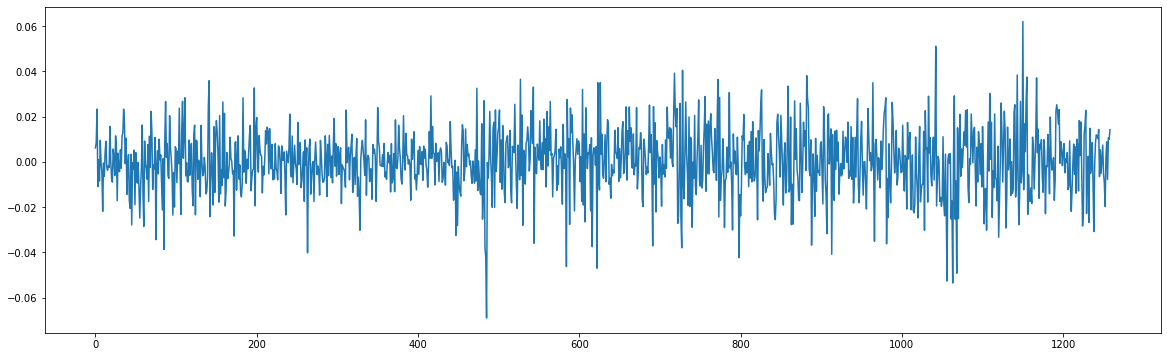

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(X)
plt.show()

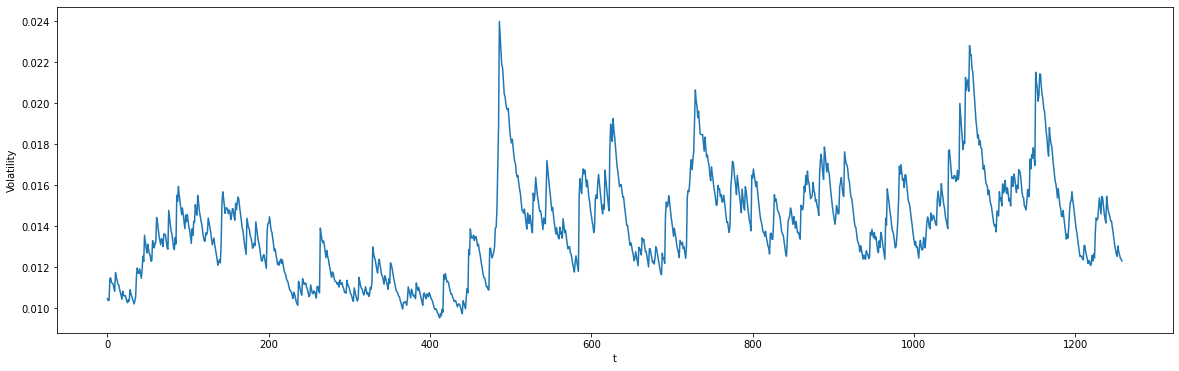

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(results._volatility)
plt.xlabel("t")
plt.ylabel("Volatility")
plt.show()

c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


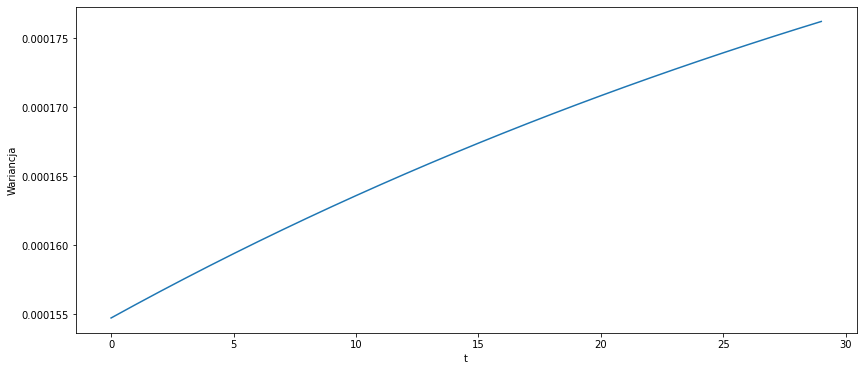

In [14]:
vars = results.forecast(horizon=30).variance.iloc[-1,:]

plt.figure(figsize=(14, 6))
plt.plot(range(len(vars)), vars)
plt.xlabel("t")
plt.ylabel("Wariancja")
plt.show()

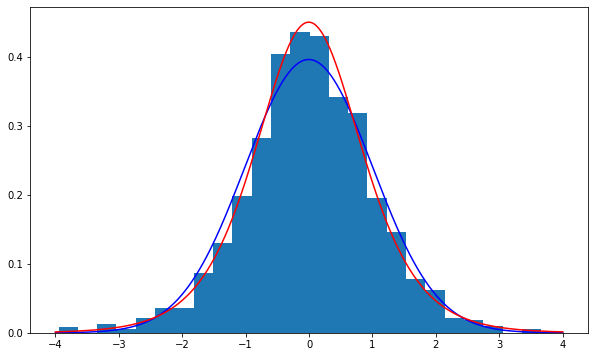

In [15]:
L = results.std_resid
plt.figure(figsize=(10, 6))
plt.hist(L, bins=25, density=True)
xs = np.linspace(-4, 4, 1000)
plt.plot(xs, sp.norm.pdf(xs, np.mean(L), np.std(L)), c='blue')
plt.plot(xs, sp.logistic.pdf(xs, np.mean(L), np.sqrt(3)/np.pi * np.std(L)), c='red')
plt.show()

In [16]:
print(float(np.quantile(L, 0.95) * np.sqrt(results.forecast().variance.iloc[-1])))
print(float(np.quantile(L, 0.99) * np.sqrt(results.forecast().variance.iloc[-1])))

c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [17]:
sigma_30 = results.forecast(horizon=30).variance.iloc[-1,:][-1]

print(float(np.quantile(L, 0.95) * np.sqrt(sigma_30)))
print(float(np.quantile(L, 0.99) * np.sqrt(sigma_30)))

c:\Users\Filip\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


# Geometrycznny ruch Browna

In [18]:
mu = np.mean(np.log(Y[1:] / Y[:-1]))
sigma = stdev(np.log(Y[1:] / Y[:-1]))

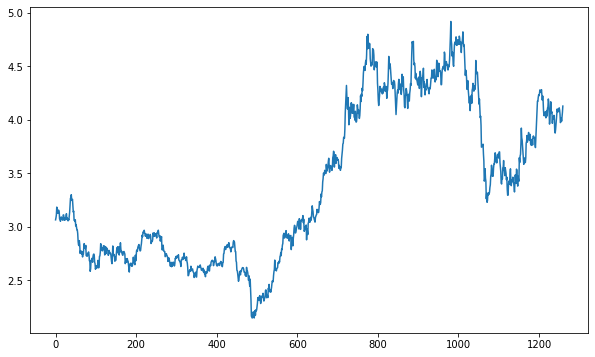

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(Y)
plt.show()

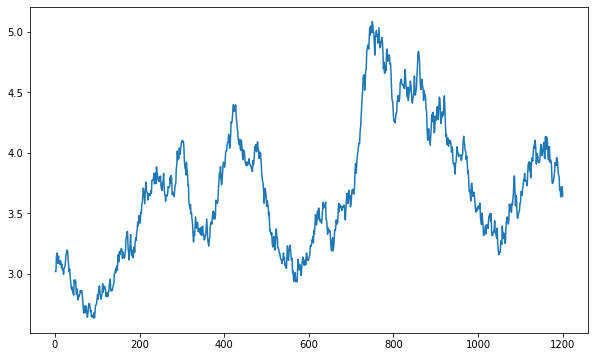

In [20]:
T = 1200
#S0 = Y[-1]
S0 = 3
n = 1000
ts = np.linspace(T/n, T, n)
Bt = np.cumsum(sp.norm.rvs(0, np.sqrt(T/n), n))
St = S0 * np.exp((mu - sigma**2 / 2) * ts + sigma * Bt)

plt.figure(figsize=(10, 6))
plt.plot(ts, St)
plt.show()

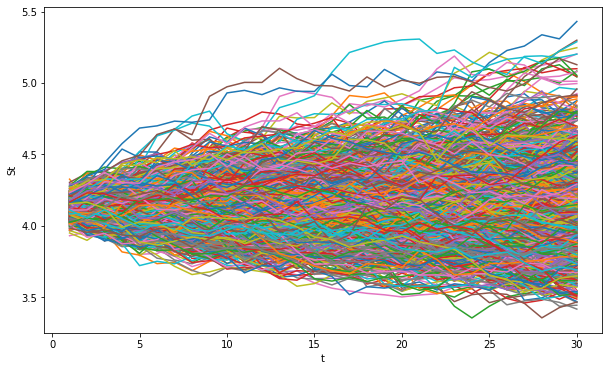

In [21]:
T = 30
S0 = Y[-1]
n = 30
ts = np.linspace(T/n, T, n)

plt.figure(figsize=(10, 6))
MC = 1000
St_table = np.zeros((n, MC))
for i in range(MC):
    Bt = np.cumsum(sp.norm.rvs(0, np.sqrt(T/n), n))
    St = S0 * np.exp((mu - sigma**2 / 2) * ts + sigma * Bt)
    St_table[:, i] = St
    plt.plot(ts, St)

plt.xlabel("t")
plt.ylabel("St")
plt.show()

In [22]:
T = 30
S0 = Y[-1]
n = 30
ts = np.linspace(T/n, T, n)

MC = 10000
St_table = np.zeros((n, MC))
for i in range(MC):
    Bt = np.cumsum(sp.norm.rvs(0, np.sqrt(T/n), n))
    St = S0 * np.exp((mu - sigma**2 / 2) * ts + sigma * Bt)
    St_table[:, i] = St

print(np.quantile(St_table[-1,:], 0.95))
print(np.quantile(St_table[-1,:], 0.99))

In [23]:
loc = S0 * np.exp(mu * 30)
s = S0**2 * np.exp(2 * mu * 30) * (np.exp(sigma**2 * 30) - 1)

print(sp.lognorm.ppf(0.95, s=np.sqrt(s), loc=loc, scale=1))
print(sp.lognorm.ppf(0.99, s=np.sqrt(s), loc=loc, scale=1))

In [24]:
loc = np.log(S0) + (mu - 1/2 * sigma**2) * 30
s = sigma * np.sqrt(30)

print(sp.lognorm.ppf(0.95, s=s, loc=loc, scale=1))
print(sp.lognorm.ppf(0.99, s=s, loc=loc, scale=1))

# Backtesting

In [25]:
def backtesting_emp(n, alpha):
    I = 0
    for i in range(len(X) - n - 1):
        I += np.quantile(X[i:i+n+1], alpha) > X[i+n+1]
    return I / (len(X) - n)

In [26]:
def backtesting_param(n, alpha):
    I = 0
    for i in range(len(X) - n - 1):
        I += sp.logistic.ppf(alpha, np.mean(X[i:i+n+1]), np.sqrt(3)/np.pi*stdev(X[i:i+n+1])) > X[i+n+1]
    return I / (len(X) - n)

In [27]:
def backtesting_garch(n, alpha):
    with contextlib.redirect_stdout(io.StringIO()):
        I = 0
        for i in range(len(X) - n - 1):
            model = arch.arch_model(X[i:i+n+1], vol='GARCH', p=1, q=1)
            results = model.fit()
            L = results.std_resid
            I += float(np.quantile(L, alpha) * np.sqrt(results.forecast().variance.iloc[-1])) > X[i+n+1]
    return I / (len(X) - n)

In [36]:
def backtesting_weight(n, alpha, lam):
    I = 0
    for i in range(len(X) - n - 1):
        I +=  hist_weight_fun(lam,alpha,X[i:i+n+1]) > X[i+n+1]
    return I / (len(X) - n)

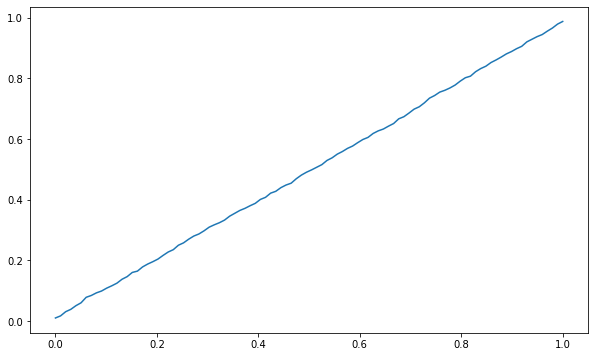

In [28]:
alphas = np.linspace(0, 1, 100)
qs = backtesting_emp(100, alphas)

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.show()

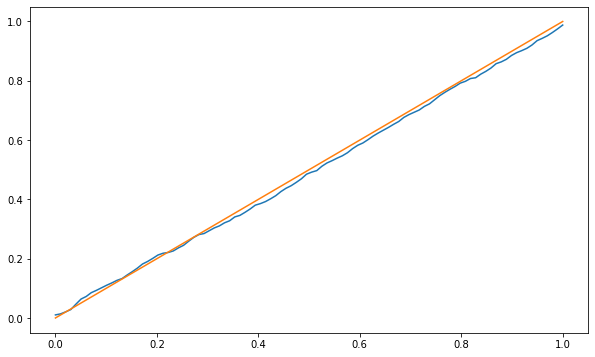

In [42]:
alphas = np.linspace(0, 1, 100)
qs = backtesting_weight(100, alphas,0.97)

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.plot(alphas,alphas)
plt.show()

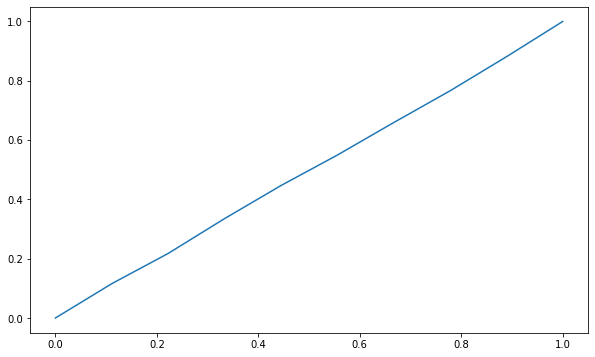

In [29]:
alphas = np.linspace(0, 1, 10)
qs = []
for alpha in alphas:
    q = backtesting_param(100, alpha)
    qs.append(q)

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.show()